In [27]:
import numpy as np
from PIL.features import check
from numpy.ma.core import indices
import matplotlib.pyplot as plt

In [3]:
# params --> jakiś specjalny plik json
# od razu funkcja taka, żeby z tym działało,
# ale wczytanie danych do formatu pythona przed
# tą funkcją

# czy my checemy jakąś osobną funkcję do zamiany
# danych na json??? (chyba)

# position weight matrix:
tmp = np.array([[3/8,1/8,2/8,2/8],[1/10,2/10,3/10,4/10],[1/7,2/7,1/7,3/7]])
Theta = tmp.T

# background distribution
ThetaB=np.array([1/4,1/4,1/4,1/4])

params = {
    "w" : 3,
    "alpha" : 0.5,
    "k" : 10,
    "Theta" : Theta.tolist(),
    "ThetaB" : ThetaB.tolist()
    }

# setup to są te słowniki params
def generate_data(setup):
    # wartości, z których chcemy robić ciągi
    values = np.array([1, 2, 3, 4])

    w, alpha, k, Theta, ThetaB = setup.values()
    Theta = np.asarray(Theta)
    ThetaB = np.asarray(ThetaB)

    X = np.empty((k, w))
    mask = np.full((k, w), False)
    # losujemy, z jakiego rozkładu ma pochodzić rząd (próba)
    probs = np.random.rand(k)
    chosen_rows = probs <= alpha
    mask[chosen_rows] = True

    for i in range(w):
        col_mask = mask[:,i]
        m = np.sum(col_mask)
        m_val = np.random.choice(values, m, p = Theta[:,i])

        X[:,i][col_mask] = m_val

    b = np.sum(~mask)
    b_val = np.random.choice(values, b, p = ThetaB)
    X[~mask] = b_val

    return {"alpha": alpha,
            "data": X}


In [76]:
# liczy odległość między rozkładami
# działa dla Theta i ThetaB
# dla alpha liczone osobno
def tv_dist(origin, est):
    return np.sum(np.sum(np.abs(origin - est), axis = 0) / 2)

def initialize_params(X, method = "data"):
    # na wszelki wypadek sobie zmieniamy
    X = np.asarray(X)
    k, w = X.shape

    if method == "data":
        ThetaB = np.empty(4)
        Theta = np.empty([4, w])
        for i in [1, 2, 3, 4]:
            mask = X == i
            row = i - 1
            ThetaB[row] = np.sum(mask) / (k * w)
            Theta[row, :] = np.sum(mask, axis=0) / k
        return Theta, ThetaB

    elif method == "uniform":
        # Jednolity rozkład
        Theta = np.ones([4, w]) / 4
        ThetaB = np.ones(4) / 4
        return Theta, ThetaB

    elif method == "random":
        ThetaB = np.zeros(4)
        ThetaB[:(4-1)]=np.random.rand(4-1)/4
        ThetaB[4-1]=1-np.sum(ThetaB)
        
        # each column add up to 1
        Theta = np.zeros((4,w))
        Theta[0:3,:] = np.random.random((3,w))/w
        Theta[3,:] = 1 - np.sum(Theta, axis=0)
        return Theta, ThetaB

    else:
        raise ValueError("Invalid argument for function initialize_params")


def EM(data, est_alpha = False, max_iter = 1000, err = 1e-5, init_method = "data"):
    alpha, X = data.values()
    Theta, ThetaB = initialize_params(X, method = init_method)
    k, w = X.shape

    row_indices = np.intp(X - 1)
    col_indices = np.tile(np.arange(w), (k, 1))

    if est_alpha:
        alpha = 0.5 # zapominamy, że znamy alpha i je estymujemy, a tu inicjalizacja

    dist = 1
    iter = 0
    history = []
    
    while dist > err and iter < max_iter:
        iter += 1

        # wartości Theta, dostosowane do obliczeń
        Theta_c = Theta[row_indices, col_indices]
        ThetaB_c = ThetaB[row_indices]

        f = np.prod(Theta_c, axis = 1)
        fB = np.prod(ThetaB_c, axis = 1)

        # te, Z co są równe 1
        latent = f * alpha / ((f * alpha) + (fB * (1 - alpha)))
        # żeby umożliwić działania wektorowe
        latent = latent[:, np.newaxis]
        Theta_lam = np.sum(latent)
        ThetaB_lam = np.sum(1 - latent) * w

        alpha_est = alpha

        if est_alpha:
            alpha_est = np.mean(latent)

        Theta_est = Theta.copy()
        ThetaB_est = ThetaB.copy()

        for i in [1, 2, 3, 4]:
            mask = X == i
            row = i - 1

            ThetaB_est[row] = np.sum(mask * (1 -  latent)) / ThetaB_lam
            Theta_est[row, :] = np.sum(mask * latent, axis=0) / Theta_lam

        if est_alpha:
            dist = (tv_dist(Theta, Theta_est) + tv_dist(ThetaB, ThetaB_est) + np.abs(alpha - alpha_est) / 2) / (w + 2)
            alpha = alpha_est
        else:
            dist = (tv_dist(Theta, Theta_est) + tv_dist(ThetaB, ThetaB_est)) / (w + 1)

        history.append(dist)
        Theta = Theta_est
        ThetaB = ThetaB_est

    return {"alpha": alpha,
            "Theta": Theta,
            "ThetaB": ThetaB,
           "history":history}

some notes:
- different initialization methods (random, uniform, the natural initialization is the one oktawia already implemented i think)
- EM convergency
- d_{tv} depending on starting \alpha
- does knowing the alpha improve d_{tv}?
- 
- 

In [91]:
np.random.seed(42)
# dane 
tmp = np.array([[3/8,1/8,2/8,2/8],[1/10,2/10,3/10,4/10],[1/7,2/7,1/7,3/7]])
Theta = tmp.T
ThetaB=np.array([1/4,1/4,1/4,1/4])

params = {
    "w" : 3,
    "alpha" : 0.1,
    "k" : 200,
    "Theta" : Theta.tolist(),
    "ThetaB" : ThetaB.tolist()
    }


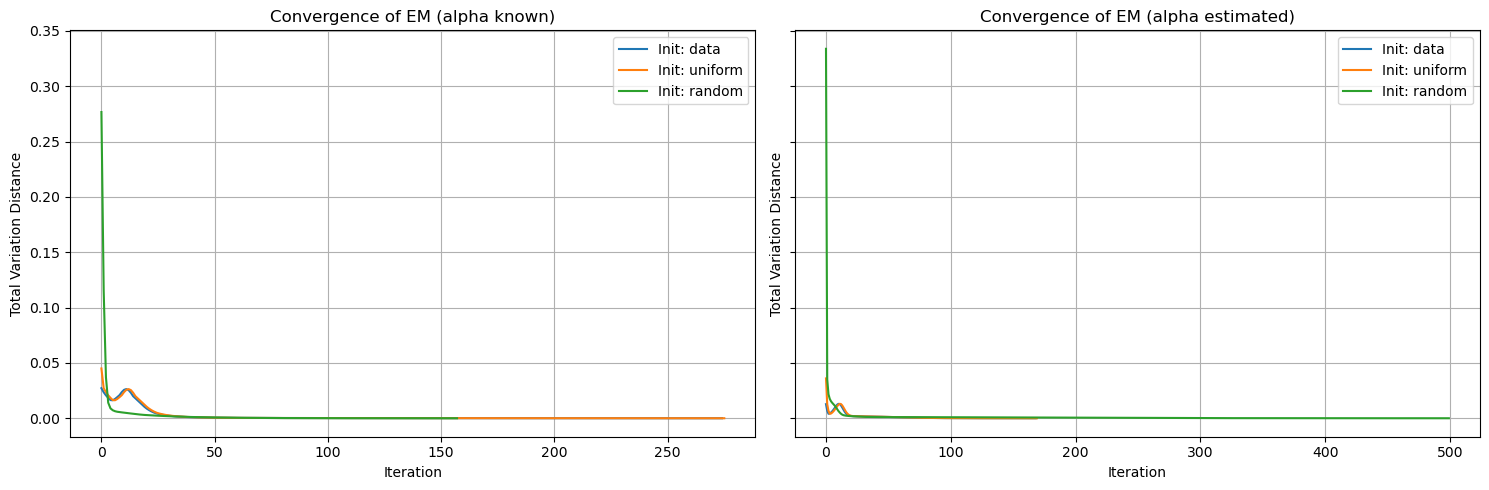

In [101]:
init_methods = ["data", "uniform", "random"]
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

np.random.seed(0)
data = generate_data(params)

for ax, est_alpha in zip(axes, [False, True]):
    for method in init_methods:
        results = EM(data, init_method=method, est_alpha=est_alpha)
        ax.plot(results["history"], label=f"Init: {method}")
    
    ax.set_title(f"Convergence of EM (alpha {'estimated' if est_alpha else 'known'})")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Total Variation Distance")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()



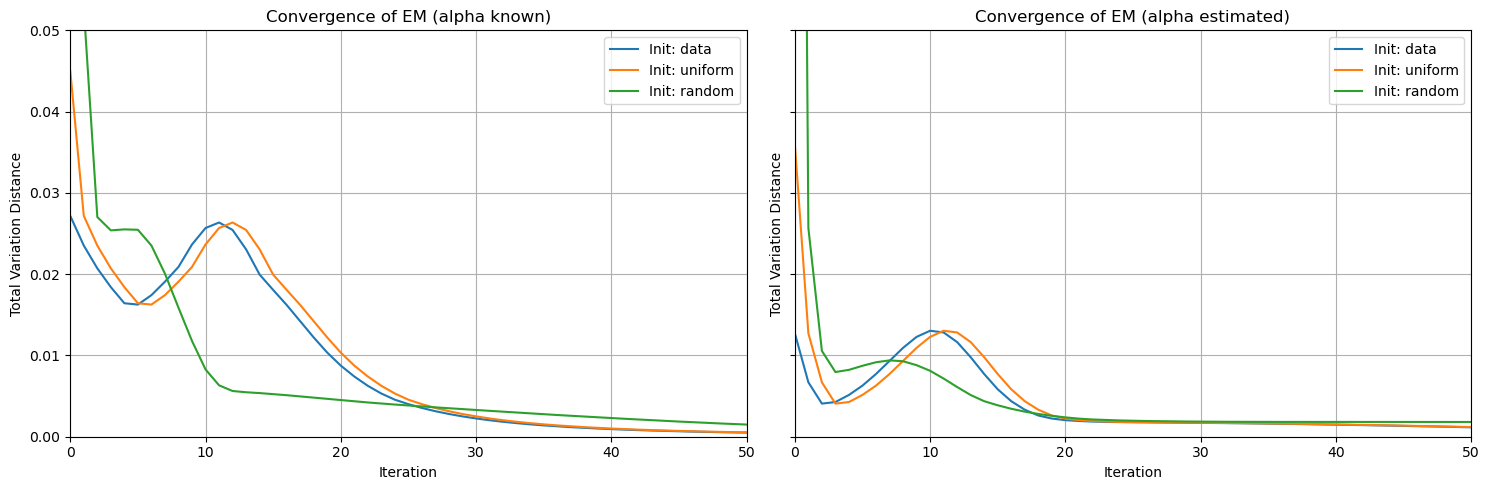

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for ax, est_alpha in zip(axes, [False, True]):
    for method in init_methods:
        results = EM(data, init_method=method, est_alpha=est_alpha)
        ax.plot(results["history"], label=f"Init: {method}")
    
    ax.set_title(f"Convergence of EM (alpha {'estimated' if est_alpha else 'known'})")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Total Variation Distance")
    ax.set_xlim(0, 50) # zblizenie na roznice
    ax.set_ylim(0, 0.05)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

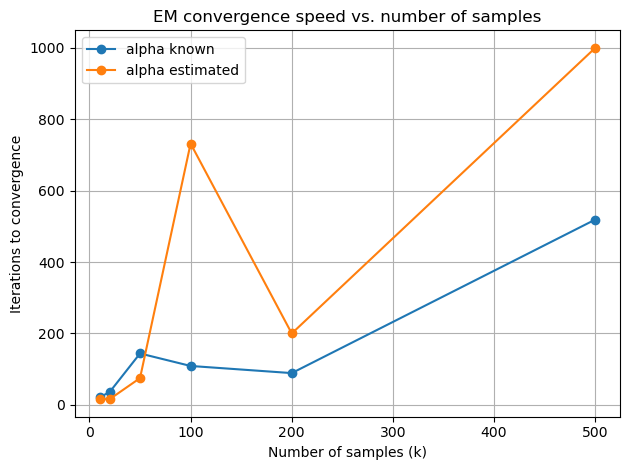

In [105]:
ks = [10, 20, 50, 100, 200, 500]
init_method = "uniform"
iterations_known = []
iterations_estimated = []

for k in ks:
    params["k"] = k
    data = generate_data(params)

    res_known = EM(data, init_method=init_method, est_alpha=False)
    iterations_known.append(len(res_known["history"]))

    res_est = EM(data, init_method=init_method, est_alpha=True)
    iterations_estimated.append(len(res_est["history"]))

plt.plot(ks, iterations_known, marker='o', label='alpha known')
plt.plot(ks, iterations_estimated, marker='o', label='alpha estimated')
plt.xlabel("Number of samples (k)")
plt.ylabel("Iterations to convergence")
plt.title("EM convergence speed vs. number of samples")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

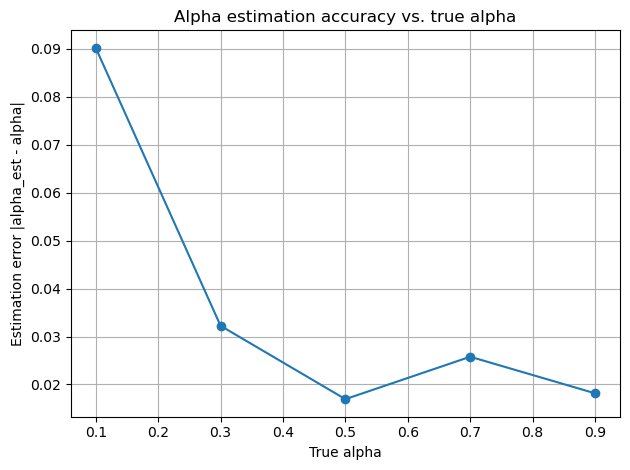

In [113]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha_errors = []

for alpha in alphas:
    params["alpha"] = alpha
    data = generate_data(params)

    res = EM(data, init_method="random", est_alpha=True)
    alpha_est = res["alpha"]
    alpha_errors.append(abs(alpha_est - alpha))

plt.plot(alphas, alpha_errors, marker='o')
plt.xlabel("True alpha")
plt.ylabel("Estimation error |alpha_est - alpha|")
plt.title("Alpha estimation accuracy vs. true alpha")
plt.grid()
plt.tight_layout()
plt.show()


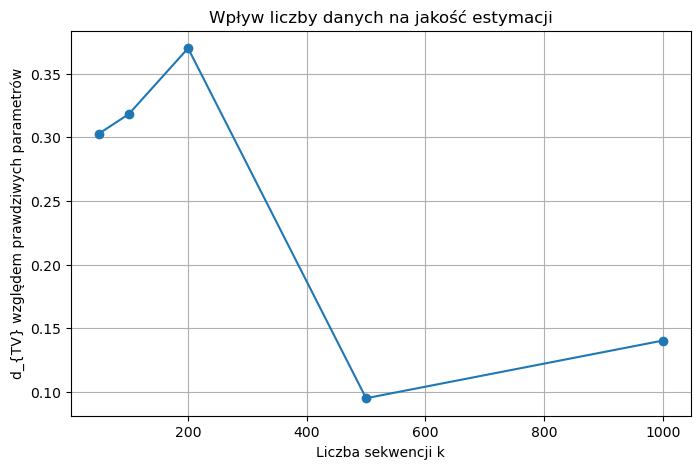

In [50]:
def true_vs_estimated_dtv(Theta_true, ThetaB_true, Theta_est, ThetaB_est):
    w = Theta_true.shape[1]
    dtv_background = np.sum(np.abs(ThetaB_true - ThetaB_est)) / 2
    dtv_columns = np.sum([np.sum(np.abs(Theta_true[:, i] - Theta_est[:, i])) / 2 for i in range(w)])
    return (dtv_background + dtv_columns) / (w + 1)

k_values = [50, 100, 200, 500, 1000]
d_tv_vs_k = []

for k in k_values:
    params_k = params.copy()
    params_k["k"] = k
    data_k = generate_data(params_k)
    results_k = EM(data_k, est_alpha=True)
    
    # TU: liczymy odległość względem prawdziwych parametrów!
    final_dtv = true_vs_estimated_dtv(Theta, ThetaB, results_k["Theta"], results_k["ThetaB"])
    d_tv_vs_k.append(final_dtv)

plt.figure(figsize=(8, 5))
plt.plot(k_values, d_tv_vs_k, marker="o")
plt.xlabel("Liczba sekwencji k")
plt.ylabel("d_{TV} względem prawdziwych parametrów")
plt.title("Wpływ liczby danych na jakość estymacji")
plt.grid()
plt.show()
